<a href="https://colab.research.google.com/github/jpbeccaria/Other-proyects/blob/main/Applying_Classification_Models_to_a_Health_Education_Survey_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importamos dependencias necesarias

## *Trabajo práctico N° 3*

## Importamos dependencias necesarias

In [ ]:
import re
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


## Cargamos el dataset a usar

En este caso se trata de un encuesta de salud alimenticia, mental, sexual, acompañamiento familiar, condiciones de vida, entre varios otros factores.
Tres de esas preguntas hacen referencia a pensamientos o intentos de suicidio por parte de los chicos y chicas encuestadas.
Nuestra hipótersis es que las la información de las respuestas en la encuesta de salud escolar tiene un poder predictivo en saber si los chicos pensaron alguna vez seriamente en quitarse la vida.
Consideramos que un abordaje como este, por supuesto que con herramentas más complejas y llevado a cabo por profesionales con más experiencia en el tema, puede ser de importancia para la Salud pública, para detectar prematuramente a personas que estan pasando un mal momento en su vida e intentar contenerlas y ayudarlas a tiempo.

In [ ]:
# Comensemos importando el dataset

csv_url = "https://drive.google.com/uc?id=1nkBC4vXcpUh7X0Qfs5CAJuo0XGBLbvYL"
output = "/content/EMSE_DatosAbiertos.csv"

gdown.download(csv_url, output, quiet=False)
data = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1nkBC4vXcpUh7X0Qfs5CAJuo0XGBLbvYL
To: /content/EMSE_DatosAbiertos.csv
100%|██████████| 108M/108M [00:01<00:00, 56.3MB/s] 


In [ ]:
# Verificar los datos y veamos qué pinta tienen
data.head()

,sitio,record,q1,texto_q1,q2,texto_q2,q3,texto_q3,q4,q5,...,texto_qnpa5g,qnpa7g,texto_qnpa7g,qnpe3g,texto_qnpe3g,qnpe5g,texto_qnpe5g,weight,stratum,psu
0,AG,1,3.0,13 años,2.0,Femenino,2.0,9no grado nivel Primario/Polimodal o 2do año n...,NaN,NaN,...,Si,1.0,Si,2.0,No,2.0,No,457.09,201801010,19
1,AG,2,3.0,13 años,2.0,Femenino,2.0,9no grado nivel Primario/Polimodal o 2do año n...,NaN,NaN,...,Si,2.0,No,2.0,No,2.0,No,457.09,201801010,19
2,AG,3,4.0,14 años,1.0,Masculino,4.0,2do año/11vo grado nivel Polimodal o 4to año n...,1.67,56.0,...,Si,2.0,No,2.0,No,2.0,No,261.44,201801010,19
3,AG,4,6.0,16 años,1.0,Masculino,2.0,9no grado nivel Primario/Polimodal o 2do año n...,1.73,70.0,...,No,2.0,No,1.0,Si,1.0,Si,550.90,201801010,19
4,AG,5,3.0,13 años,2.0,Femenino,2.0,9no grado nivel Primario/Polimodal o 2do año n...,NaN,NaN,...,No,2.0,No,2.0,No,2.0,No,457.09,201801010,19


In [ ]:
data.shape

(56981, 309)

El dataset tiene 56981 entradas con 310 features; sin embargo algunas de las categorias cuentan con información están repetidas; las columnas correspondientes a preguntas cuya respuesta es en forma de texto, fueron convertidas a número por quienes crearon el dataset.

La pregunta numero 24 del dataset es la refiere a: "Durante los últimos 12 meses, ¿alguna vez consideraste seriamente la posibilidad de intentar suicidarte?". Junto con la 25 y la 26 son las únicas tres preguntas que abordan este tema de manera directa.
Veamos cómo se distribuyen los casos que responde de manera afirmativa o negativa frente a esta pregunta.

In [ ]:
data.q24

0        1.0
1        2.0
2        NaN
3        2.0
4        2.0
        ... 
56976    2.0
56977    2.0
56978    2.0
56979    2.0
56980    2.0
Name: q24, Length: 56981, dtype: float64

Las respuestas de la pregunta 24 están codificadas como "1" para "Si" o "2" para "No". Esto no es del agrado de algunas de las herramientas que utilizaremos en el TP (como las curvas ROC) asi que aprovechemos para hacer el reemplazo por una codificación más intuitiva: 0 = "No", 1 = "Si".

In [ ]:
data['q24'] = data['q24'].replace({2.0: 0})

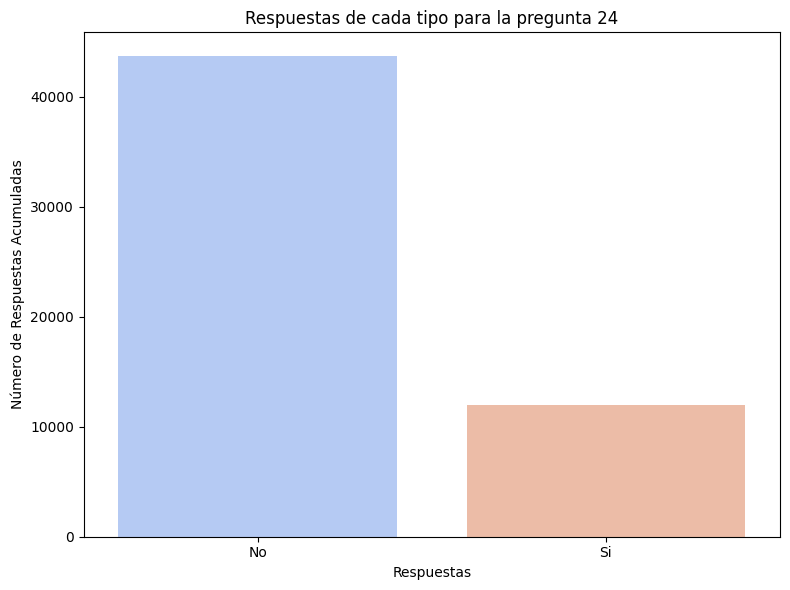

In [ ]:
casos_por_tipo = data['q24'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=casos_por_tipo.index, y=casos_por_tipo.values, palette='coolwarm')
plt.xlabel('Respuestas')
plt.ylabel('Número de Respuestas Acumuladas')
plt.title('Respuestas de cada tipo para la pregunta 24')
plt.xticks(ticks=[0, 1], labels=['No', 'Si'])
plt.tight_layout()
plt.show()


In [ ]:
print(casos_por_tipo)
print(casos_por_tipo[1]/(casos_por_tipo.sum()))

0.0    43666
1.0    11962
Name: q24, dtype: int64
0.2150355935859639


Podemos ver que mas del 20% de las chicos y chicos que contestaron la encuesta pensaron seriamente en suicidarse en los ultimos 12 meses.

Hagamos un poco de limpieza del dataset. Hay features que estan duplicadas: respuesta en texto, y su equivalente como respuesta codificada en números- Quedémonos solo con las respuestas numéricas. Esto es fácil de hacer porque afortunadamente todas las features con respuestas en forma de texto cuentan con la palabra "texto" en su encabezado.

In [ ]:
data.columns

Index(['sitio', 'record', 'q1', 'texto_q1', 'q2', 'texto_q2', 'q3', 'texto_q3',
       'q4', 'q5',
       ...
       'texto_qnpa5g', 'qnpa7g', 'texto_qnpa7g', 'qnpe3g', 'texto_qnpe3g',
       'qnpe5g', 'texto_qnpe5g', 'weight', 'stratum', 'psu'],
      dtype='object', length=309)

In [ ]:
# PASO IMPORTANTE, eliminamos las columas que tienen texto.
# El dataset tiene info por duplicado, las columnas de "texto" (ej "si", "no", "a veces"; ya viene transformadas transformadas a números)

data = data.filter(regex=r'^(?!.*texto).*$', axis=1)

# Aprovechemos que estamos quitando columnas con texto y quitemos la columna "sitio" que solo dice "AG" (por Argentina) para todos los casos

data = data.drop(['sitio'], axis=1)

Alguno de los algoritmos que utilizaremos, como KNN no soportan NaN. Por ello dropearemos las columnas con un alto porcentaje de nulos y luego las entradas que tengan al menos un nulo. Hacemos esto y en este orden porque si en primera instancia eliminaos las entradas con algún nulo, todas las filas son eliminadas.

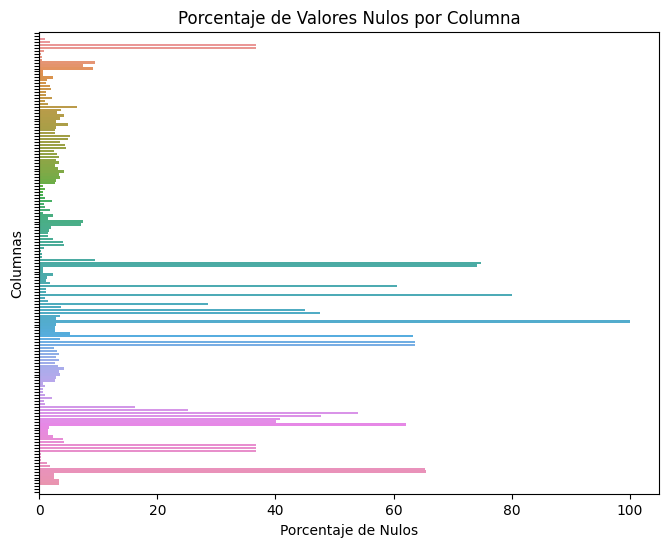

In [ ]:
# Miremos un pantallazo qué cantidad de nulos presenta el dataset:

def graficar_nulos(data):
    null_percentages = data.isnull().sum() / len(data) * 100
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=null_percentages.values, y=null_percentages.index, ax=ax)
    ax.set_xlabel('Porcentaje de Nulos')
    ax.set_ylabel('Columnas')
    ax.set_title('Porcentaje de Valores Nulos por Columna')
    ax.set_yticklabels([])
    plt.show()

graficar_nulos(data)

In [ ]:
#Exceptuando unas pocas columnas, en general no hay tantos nulos.

porcentaje_no_nulos = data.notnull().mean()

# Obtener las columnas con un porcentaje de NaN mayor al 20%

columnas_altos_nulos = porcentaje_no_nulos[porcentaje_no_nulos < 0.8].index

# Eliminar las columnas con un porcentaje de NaN mayor al 20%
data_filtrado = data.drop(columnas_altos_nulos, axis=1)


# Imprimir el DataFrame resultante
print(data_filtrado)

       record   q1   q2   q3   q6  q10  q15  q16  q17  q18  ...  qnff3g  \
0           1  3.0  2.0  2.0  2.0  1.0  1.0  1.0  1.0  1.0  ...     2.0   
1           2  3.0  2.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  ...     2.0   
2           3  4.0  1.0  4.0  1.0  1.0  1.0  1.0  3.0  2.0  ...     2.0   
3           4  6.0  1.0  2.0  1.0  4.0  1.0  3.0  1.0  1.0  ...     1.0   
4           5  3.0  2.0  2.0  1.0  1.0  1.0  1.0  NaN  NaN  ...     2.0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...   
56976   57091  6.0  1.0  5.0  4.0  1.0  1.0  4.0  2.0  3.0  ...     2.0   
56977   57092  6.0  1.0  5.0  3.0  1.0  1.0  1.0  1.0  1.0  ...     2.0   
56978   57093  6.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  ...     2.0   
56979   57094  6.0  2.0  5.0  1.0  1.0  1.0  1.0  2.0  2.0  ...     2.0   
56980   57095  6.0  2.0  5.0  2.0  1.0  1.0  1.0  NaN  NaN  ...     2.0   

       qntob2g  qnnotb2g  qnpa5g  qnpa7g  qnpe3g  qnpe5g  weight    stratum  \
0          1.0      

In [ ]:
# Ahora si dropeamos las filas que tengan algun nulo

data_sin_nulos = data_filtrado.dropna()
data_sin_nulos.shape

(24774, 133)

In [ ]:
data_sin_nulos.q24.value_counts().unique

<bound method Series.unique of 0.0    19831
1.0     4943
Name: q24, dtype: int64>

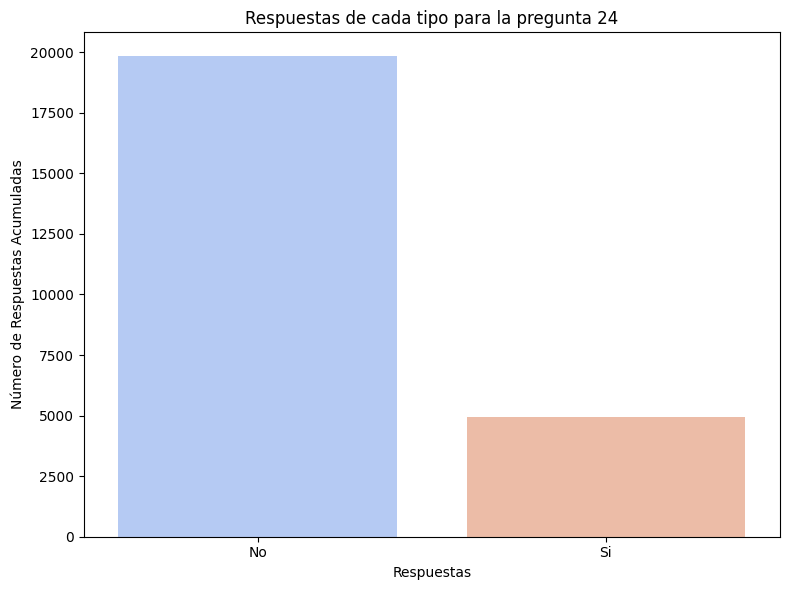

In [ ]:
casos_por_tipo_limpio = data_sin_nulos['q24'].value_counts().sort_index(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=casos_por_tipo_limpio.index, y=casos_por_tipo_limpio.values, palette='coolwarm')
plt.xlabel('Respuestas')
plt.ylabel('Número de Respuestas Acumuladas')
plt.title('Respuestas de cada tipo para la pregunta 24')
plt.xticks(ticks=[0, 1], labels=['No', 'Si'])
plt.tight_layout()
plt.show()

El resultado es un dataset más chico, unas 25 mil entradas, pero que muestra un desbalance equivalente al de un comienzo (una relación 5:1 entre las respuestas). Para generar un dataset más balanceado con el que trabajar decidimos quedarlos con todos los casos en los que la respuesta a la pregunta 24 fue afirmativa, y realizar un muestreo al azar (de tamaño igual al de respuestas afirmativas) entre los casos que contestaron "No".

In [ ]:
# Guardamos las respuestas por "Si"
data_rta_si = data_sin_nulos[data_sin_nulos['q24'] == 1]
data_rta_no = data_sin_nulos[data_sin_nulos['q24'] == 0]


# muestreamos en los desaprobados
data_submuestreo = data_rta_no.sample(n=data_rta_si.shape[0], random_state=1)
data_balanceada = data_rta_si.append(data_submuestreo)

# Ya que estamos, lo desordenamos
data_balanceada = data_balanceada.sample(frac=1, random_state=42)

<ipython-input-16-4f235c337f9a>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_balanceada = data_rta_si.append(data_submuestreo)


In [ ]:
# Verificamos
data_balanceada.q24.value_counts().unique

<bound method Series.unique of 1.0    4943
0.0    4943
Name: q24, dtype: int64>

In [ ]:
data_balanceada.head()

,record,q1,q2,q3,q6,q10,q15,q16,q17,q18,...,qnff3g,qntob2g,qnnotb2g,qnpa5g,qnpa7g,qnpe3g,qnpe5g,weight,stratum,psu
47928,48006,5.0,1.0,3.0,2.0,1.0,1.0,3.0,4.0,8.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,50.74,201821001,2
19871,20104,6.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,14.94,201810001,2
34973,35235,4.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,4.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,30.11,201816007,13
8154,8376,4.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,1.0,2.0,2.0,1.0,1.0,16.97,201804001,1
28,236,3.0,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,...,1.0,2.0,1.0,2.0,2.0,2.0,2.0,402.20,201801007,14


El dataset está balanceado con 4953 casos para cada tipo de respuesta.

Evaluemos si hay alguna feature que tenga alto grado de correlación con la variable de clasificación.

q24         1.000000
q22         0.479137
q26         0.443837
q23         0.382852
q80         0.371182
qn80        0.330220
qn56        0.260009
q31         0.234737
q2          0.215855
qnnotb2g    0.207822
Name: q24, dtype: float64


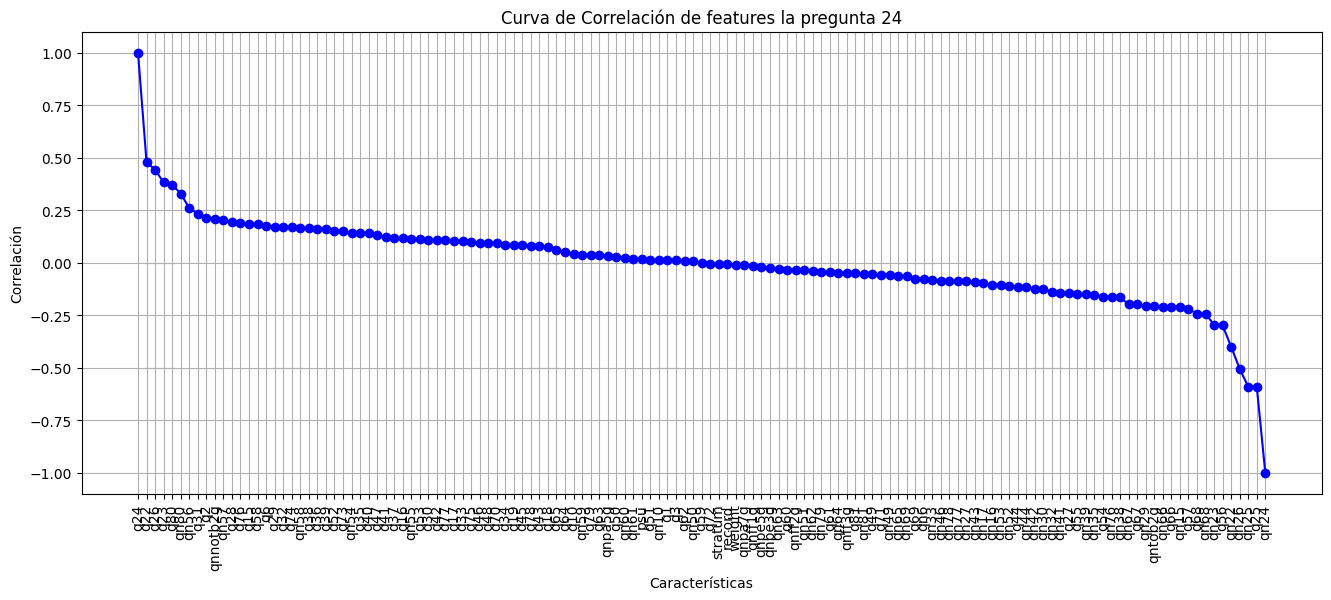

In [ ]:
correlation_matrix = data_balanceada.corr()

correlation_with_target = correlation_matrix["q24"].sort_values(ascending=False)
top_10_correlated = correlation_with_target.head(10)
print(top_10_correlated)

# Grafiquemos

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(correlation_with_target.index, correlation_with_target.values, marker='o', linestyle='-', color='b')
ax.set_xlabel('Características')
ax.set_ylabel('Correlación')
ax.set_title('Curva de Correlación de features la pregunta 24')
ax.grid(True)
plt.xticks(rotation=90)
plt.show()

Como es de esperar las preguntas que tambien abordan el suicidio tienen un alto grado de correlación con la pregunta target, como son el caso de la pregunta 25 y 26 que consultan "Durante los últimos 12 meses ¿hiciste algún plan de cómo intentarías suicidarte?" y "Durante los últimos 12 meses ¿cuántas veces intentaste realmente suicidarte?". Estas preguntas serán removidas del dataset final de análisis. Sin embargo otras preguntas como la 22, que muestra tambien un alto grado de correlación y que explora "Durante los últimos 12 meses ¿con qué frecuencia te sentiste solo o sola?" nos pareció interesante conservarla.
Asimismo, removimos las features "psu", "record" y "stratum" por ser elementos y etapas del proceso de selección de muestras representativas de una población más grande.

In [ ]:
# Aprovechamos y además de dropear las columnas con alto grado de correlación, definimos el dataset de features
X = data_balanceada.drop(['psu', 'record', 'stratum', 'q24','qn24','q25','qn25', 'q26', 'qn26'], axis=1)
X.head()

,q1,q2,q3,q6,q10,q15,q16,q17,q18,q19,...,qnff1g,qnff2g,qnff3g,qntob2g,qnnotb2g,qnpa5g,qnpa7g,qnpe3g,qnpe5g,weight
47928,5.0,1.0,3.0,2.0,1.0,1.0,3.0,4.0,8.0,8.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,50.74
19871,6.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,14.94
34973,4.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,4.0,2.0,...,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,30.11
8154,4.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,16.97
28,3.0,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,402.20


In [ ]:
# Y la serie target

y = data_balanceada['q24']
y.head()

47928    1.0
19871    0.0
34973    1.0
8154     1.0
28       0.0
Name: q24, dtype: float64

In [ ]:
# Realizamos el split entre training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [ ]:
X_train

,q1,q2,q3,q6,q10,q15,q16,q17,q18,q19,...,qnff1g,qnff2g,qnff3g,qntob2g,qnnotb2g,qnpa5g,qnpa7g,qnpe3g,qnpe5g,weight
34109,6.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,38.44
84,5.0,1.0,5.0,1.0,1.0,4.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,430.23
19990,7.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,8.0,8.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,26.94
19053,6.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,24.68
7512,4.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,21.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31424,6.0,2.0,5.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,34.79
32165,7.0,1.0,5.0,2.0,1.0,3.0,3.0,2.0,2.0,8.0,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,25.35
10889,5.0,2.0,3.0,1.0,1.0,1.0,1.0,4.0,8.0,8.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,68.00
46320,6.0,2.0,3.0,3.0,1.0,1.0,1.0,7.0,2.0,3.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,94.73


In [ ]:
# Y estandarizamos los dataset para dejarlos preparados para la aplicación de los modelos.
# Siendo que algunos de ellos se basan en distancias o cuentan con regularización, este paso es particularmente importante.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## KNN

Empecemos a aplicar modelos de clasificación, comenzando por KNN

El único hiperparámetro de KNN es el número vecinos que se evaluan. Asi que vamos a crear una función que mediante el uso de cross correlation itere entre los K posibles dentro de un rango y se quede con alquen que mejor desempeño tenga.

In [ ]:
def scores_knn_k (X, y, start, stop, step):

    # Creamos una lista de diccionarios
    scores_para_df = []

    for i in range(start,stop,step):

        # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 10 resultados, uno por cada fold que hizo automáticamente CV
        kf = KFold(n_splits=10, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours y la media y el desvío de los scores
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)

    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)

    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar, respectivamente
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

    # Retornamos el DF
    return df_scores

In [ ]:
df_scores_k = scores_knn_k(X_train, y_train, 1, 21, 1)

In [ ]:
df_scores_k

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.652143,0.022748,1,0.629395,0.674892
1,0.629482,0.026782,2,0.602700,0.656264
2,0.679526,0.023168,3,0.656358,0.702694
3,0.658078,0.025500,4,0.632578,0.683577
4,0.691934,0.020222,5,0.671712,0.712156
5,0.672645,0.017676,6,0.654970,0.690321
6,0.695172,0.019779,7,0.675393,0.714952
7,0.679927,0.024140,8,0.655787,0.704068
8,0.699621,0.021368,9,0.678253,0.720989
9,0.686132,0.017921,10,0.668211,0.704052


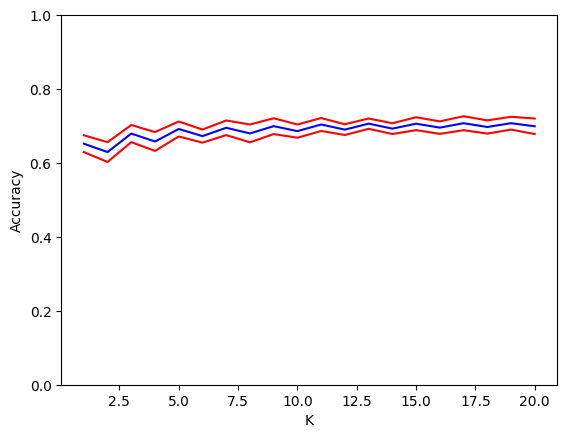

In [ ]:
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.plot(df_scores_k['n_neighbours'], df_scores_k['limite_inferior'], color='r')
plt.plot(df_scores_k['n_neighbours'], df_scores_k['score_medio'], color='b')
plt.plot(df_scores_k['n_neighbours'], df_scores_k['limite_superior'], color='r')
plt.ylim(0, 1);

In [ ]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores_k.loc[df_scores_k.score_medio == df_scores_k.score_medio.max(),'n_neighbours'].values[0]
best_k

19

In [ ]:
# Pero qué  métrica de distancia conviene usar?
# Nuevamente debemos usar cross validation para evaluar las tres formas de medir distancias más utilizadas,
# sin nunca mostrarle al modelo el dataset de entrenamiento y caer en sobreajuste

def scores_knn_metricas(X, y, k, metricas):
    # nótese que ya traemos el k, que conseguimos en la función aterior

    scores_para_df = []

    for metrica in metricas_distancia:

        # En cada iteración, evaluamos el uso de una métrica de distancias
        model = KNeighborsClassifier(n_neighbors=k, metric=metrica)

        kf = KFold(n_splits=10, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours y la media y el desvío de los scores
        dict_row_score = {'métrica': metrica,'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':k}

        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)

    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)

    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar, respectivamente
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

    # Retornamos el DF
    return df_scores

In [ ]:
metricas_distancia = ['euclidean', 'manhattan', 'chebyshev']

scores_metricas = scores_knn_metricas(X_train, y_train, best_k, metricas_distancia)

In [ ]:
scores_metricas

,métrica,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,euclidean,0.707580,0.017323,19,0.690257,0.724903
1,manhattan,0.708120,0.019051,19,0.689069,0.727171
2,chebyshev,0.644861,0.013003,19,0.631858,0.657864


In [ ]:
# La distancia Manhattan es la que presenta el mejor desempeño, por lo que será la que usemos.

In [ ]:
# Elegimos el modelo óptimo que nos había indicado cross validation
model_knn = KNeighborsClassifier(n_neighbors = best_k, metric = 'manhattan')

# Lo ajustamos sobre datos de entrenamiento
model_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=4)

In [ ]:

# Evaluamos qué accuracy obtenemos en train
y_pred_train_knn = model_knn.predict(X_train)
accuracy_score(y_train, y_pred_train_knn)

0.7586997572160777

In [ ]:
# Lo utilizamos para predecir en test
y_pred_test_knn = model_knn.predict(X_test)

In [ ]:
# Computamos el accuracy score en test
accuracy_score(y_test, y_pred_test_knn)

0.6561488673139159

In [ ]:
# Para sistematizar el análisis con los tres modelos creamos esta función que,
# A partir de los "y" predichos por cada modelo y los "y" target devuelve:

# Accuracy, Recall, Precision, F1 Score y área bajo la curba de ROC

# La función, ademas de arrojar inmediatamente las mericas del modelo evaluado
# va acumulando en un diccionario global (cada vez que ejecutemos esta función) el output que vanos consiguienteo, para al final comparar todos los modelos

result = {}

def evaluate_model(y_train, y_test, y_pred_train, y_pred_test, model_name):
    global result

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)

    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Matriz de Confusión (Train)")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Matriz de Confusión (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.tight_layout()
    plt.show()

    result[model_name] = {
        'Accuracy (Train)': accuracy_train,
        'Accuracy (Test)': accuracy_test,
        'Precision (Train)': precision_train,
        'Precision (Test)': precision_test,
        'Recall (Train)': recall_train,
        'Recall (Test)': recall_test,
        'F1 Score (Train)': f1_train,
        'F1 Score (Test)': f1_test,
        'ROC AUC (Train)': roc_auc_train,
        'ROC AUC (Test)': roc_auc_test
    }

    metrics = result[model_name]

    print("Metrics:")
    print(f"  Accuracy (Train):  {metrics['Accuracy (Train)']:.4f}")
    print(f"  Accuracy (Test):   {metrics['Accuracy (Test)']:.4f}")
    print(f"  Precision (Train): {metrics['Precision (Train)']:.4f}")
    print(f"  Precision (Test):  {metrics['Precision (Test)']:.4f}")
    print(f"  Recall (Train):    {metrics['Recall (Train)']:.4f}")
    print(f"  Recall (Test):     {metrics['Recall (Test)']:.4f}")
    print(f"  F1 Score (Train):  {metrics['F1 Score (Train)']:.4f}")
    print(f"  F1 Score (Test):   {metrics['F1 Score (Test)']:.4f}")
    print(f"  ROC AUC (Train):   {metrics['ROC AUC (Train)']:.4f}")
    print(f"  ROC AUC (Test):    {metrics['ROC AUC (Test)']:.4f}")

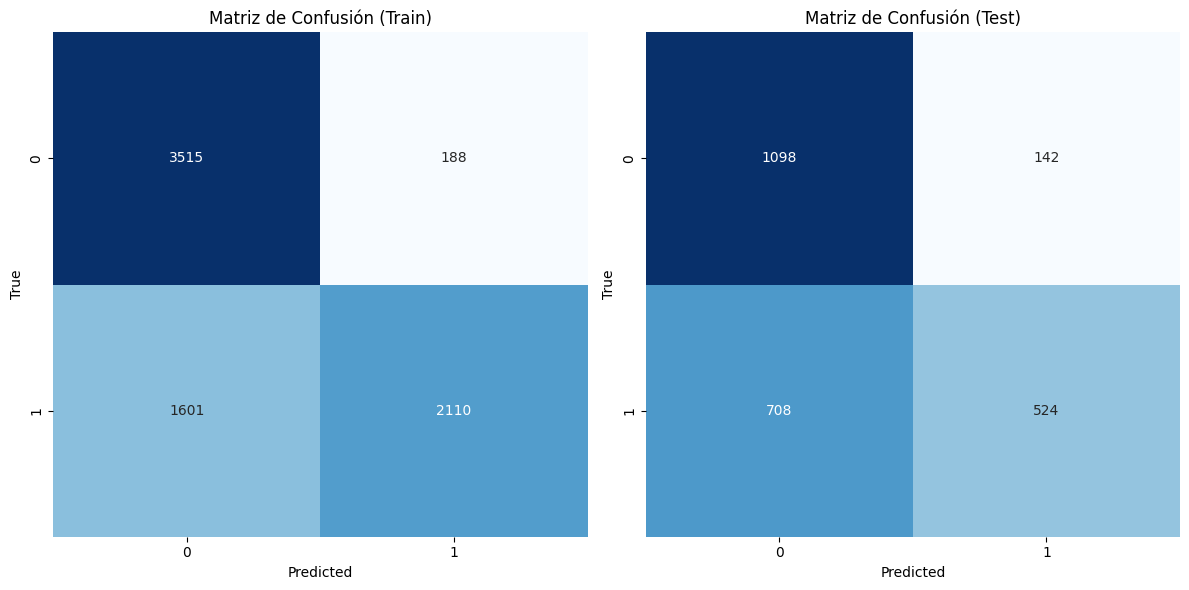

Metrics:
  Accuracy (Train):  0.7587
  Accuracy (Test):   0.6561
  Precision (Train): 0.9182
  Precision (Test):  0.7868
  Recall (Train):    0.5686
  Recall (Test):     0.4253
  F1 Score (Train):  0.7023
  F1 Score (Test):   0.5522
  ROC AUC (Train):   0.7589
  ROC AUC (Test):    0.6554


In [ ]:
evaluate_model(y_train, y_test, y_pred_train_knn, y_pred_test_knn, 'KNN')

## **Naive bayes gaussiano/multinomial**



In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(7414, 124)
(2472, 124)
(7414,)
(2472,)


In [ ]:
# instanciamos el modelo de naive bayes gaussiano

model_bayes = GaussianNB()

# lo fitteamos a nuestros datos
model_bayes.fit(X_train, y_train)

GaussianNB()

In [ ]:
# pruebo el modelo entrenado en los datos de test para ver si funciona
y_pred_bayes_test = model_bayes.predict(X_test)
y_pred_bayes_train = model_bayes.predict(X_train)

y_pred_bayes_test

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:
# calculo el accuracy del modelo

accuracy_score(y_test, y_pred_bayes_test)

0.6921521035598706

In [ ]:
# 0.69 es un buen resultado, lo comparo con la precision del null, prediciendo los resultados como si fuesen todos 1, ya que son la mayoria

y_train.value_counts()

1.0    3711
0.0    3703
Name: q24, dtype: int64

In [ ]:
# como era esperado de un dataset balanceado, el null accuracy esta cerca del 0.5, esto solidifica al resultado de nuesto modelo, mostrando que no fue al azar

tp = 3711
tn = 0
fp = 3703
fn = 0
null_accuracy = (tp + tn)/(tp + tn + fp + fn)
null_accuracy

0.5005395198273537

In [ ]:
# confusion matrix

conf_mat_bayes = confusion_matrix(y_test, y_pred_bayes_test)

print('Confusion matrix\n\n', conf_mat_bayes)

Confusion matrix

 [[990 250]
 [511 721]]


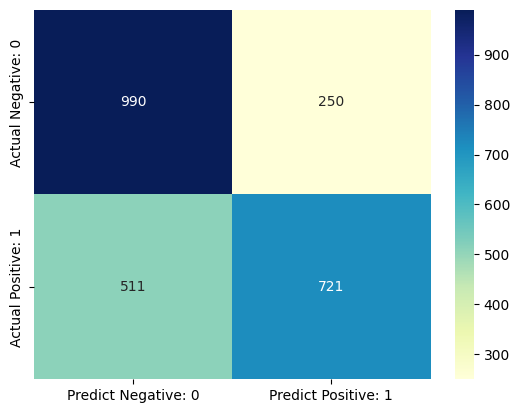

In [ ]:
conf_mat_df_bayes = pd.DataFrame(data=conf_mat_bayes,
                           index=['Actual Negative: 0', 'Actual Positive: 1'],
                           columns=['Predict Negative: 0', 'Predict Positive: 1'])

sns.heatmap(conf_mat_df_bayes, annot=True, fmt='d', cmap='YlGnBu');

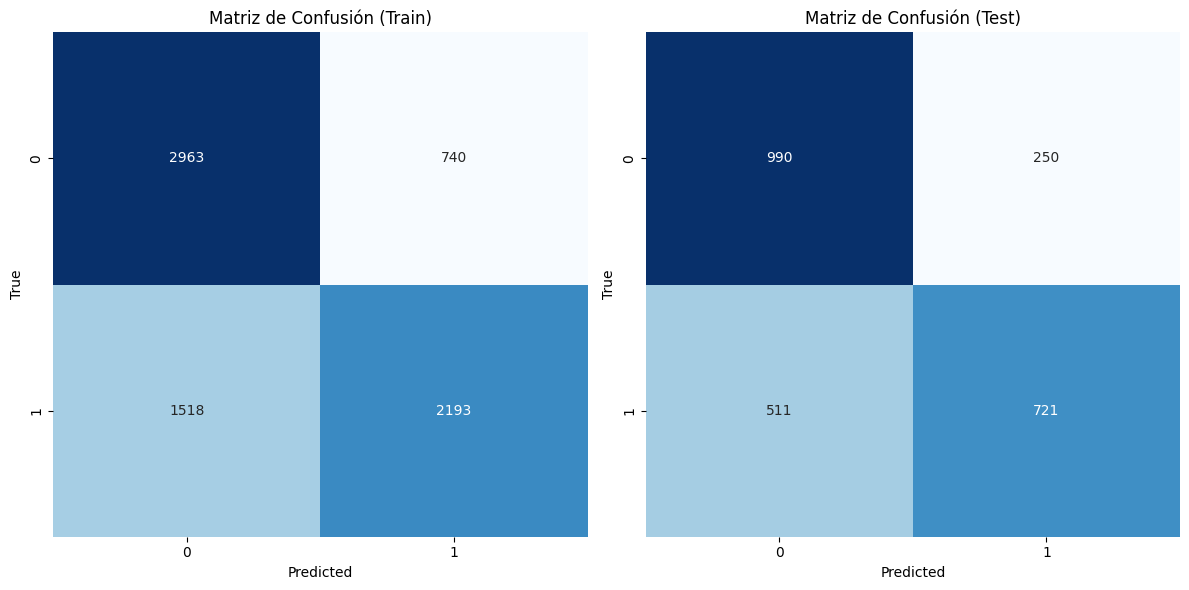

Metrics:
  Accuracy (Train):  0.6954
  Accuracy (Test):   0.6922
  Precision (Train): 0.7477
  Precision (Test):  0.7425
  Recall (Train):    0.5909
  Recall (Test):     0.5852
  F1 Score (Train):  0.6601
  F1 Score (Test):   0.6546
  ROC AUC (Train):   0.6956
  ROC AUC (Test):    0.6918


In [ ]:
evaluate_model(y_train, y_test, y_pred_bayes_train, y_pred_bayes_test, 'Naive Bayes_Gauss')

## **Naive Bayes Multinomial**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

X

,q1,q2,q3,q6,q10,q15,q16,q17,q18,q19,...,qnff1g,qnff2g,qnff3g,qntob2g,qnnotb2g,qnpa5g,qnpa7g,qnpe3g,qnpe5g,weight
47928,5.0,1.0,3.0,2.0,1.0,1.0,3.0,4.0,8.0,8.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,50.74
19871,6.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,14.94
34973,4.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,4.0,2.0,...,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,30.11
8154,4.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,16.97
28,3.0,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,402.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,3.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,402.20
46221,6.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,34.58
47302,6.0,2.0,4.0,1.0,1.0,1.0,1.0,2.0,6.0,3.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,33.53
9671,6.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,70.27


In [ ]:
# para este modelo uso un train test split diferente ya que no requiere la estandarizacion como los otros modelos. Esto es debido a que asume que sus features son discretas.

X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(X, y, random_state = 1)



In [ ]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_mnb, y_train_mnb)

MultinomialNB()

In [ ]:
# pruebo el modelo entrenado en los datos de test para ver si funciona
y_pred_mnb_train = model_mnb.predict(X_train_mnb)
y_pred_mnb_test = model_mnb.predict(X_test_mnb)

y_pred_mnb_test

array([0., 1., 0., ..., 1., 0., 0.])

In [ ]:
accuracy_score(y_test_mnb, y_pred_mnb_test)

0.6735436893203883

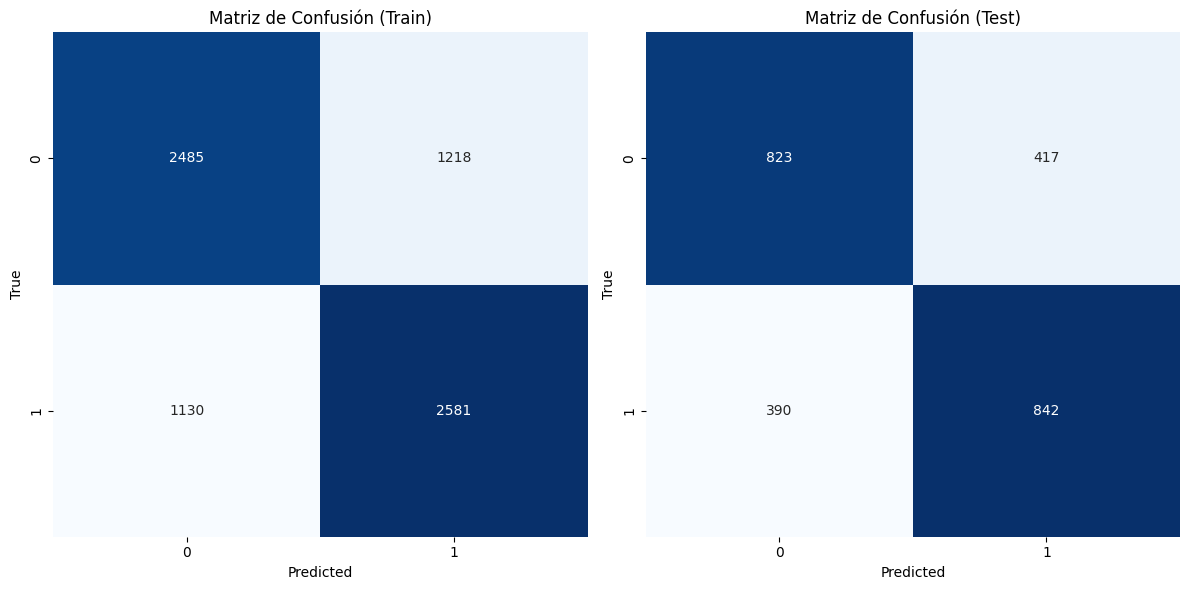

Metrics:
  Accuracy (Train):  0.6833
  Accuracy (Test):   0.6735
  Precision (Train): 0.6794
  Precision (Test):  0.6688
  Recall (Train):    0.6955
  Recall (Test):     0.6834
  F1 Score (Train):  0.6874
  F1 Score (Test):   0.6760
  ROC AUC (Train):   0.6833
  ROC AUC (Test):    0.6736


In [ ]:
evaluate_model(y_train, y_test, y_pred_mnb_train, y_pred_mnb_test, 'Naive Bayes_Multin.')

##**Regresion logistica**

Sin regularización

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


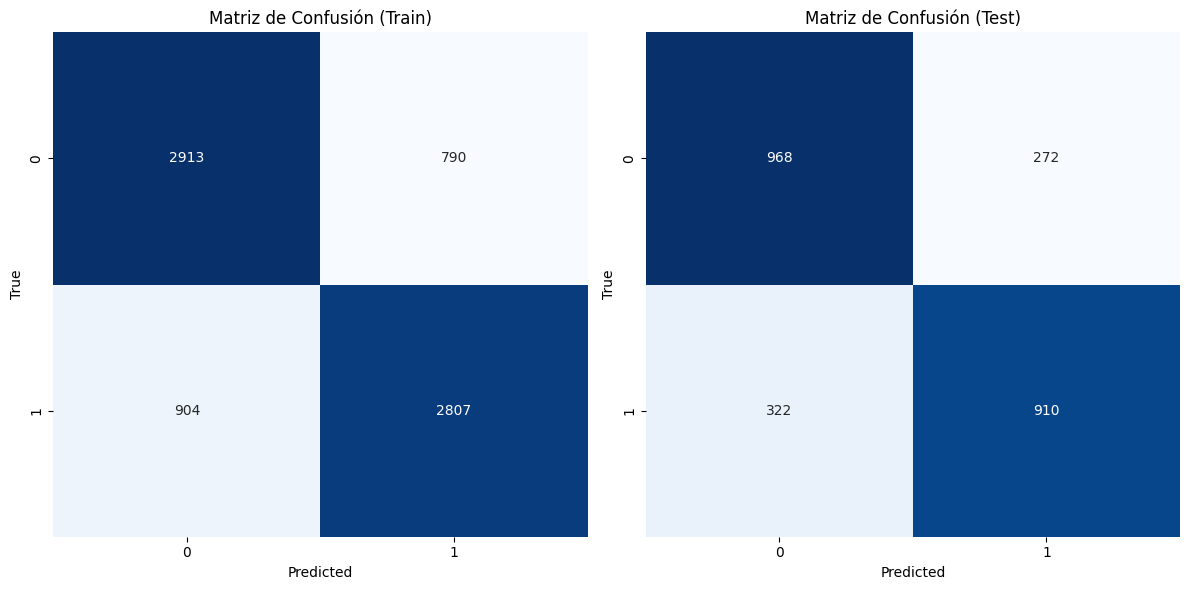

Metrics:
  Accuracy (Train):  0.7715
  Accuracy (Test):   0.7597
  Precision (Train): 0.7804
  Precision (Test):  0.7699
  Recall (Train):    0.7564
  Recall (Test):     0.7386
  F1 Score (Train):  0.7682
  F1 Score (Test):   0.7539
  ROC AUC (Train):   0.7715
  ROC AUC (Test):    0.7596


In [ ]:
#Implantamos modelo

model_lr = LogisticRegression(penalty='none')

#Entrenamos el modelo

model_lr.fit(X_train, y_train)

#Guardamos en una variable la prediccion

y_pred_lr_train = model_lr.predict(X_train)

y_pred_lr_test = model_lr.predict(X_test)

# Evaluamos modelo

evaluate_model(y_train, y_test,y_pred_lr_train,y_pred_lr_test, 'log_reg')




In [ ]:
# Intercept + Coefs

print(model_lr.intercept_)
print(model_lr.coef_)

[0.09049009]
[[-1.71300729e-01  2.18627044e-01 -9.00019693e-03  5.82193916e-02
   9.47532296e-03  1.53961048e-02  1.58044381e-01 -4.81544368e-02
  -6.33128250e-02  6.84074225e-02  6.40116927e-01  3.31546823e-01
  -5.61795941e-02 -5.51931188e-02 -9.17818851e-02  3.04103566e-02
   2.01983911e-01  5.99526537e-02  7.87285875e-02 -1.48222252e-02
  -9.52267278e-02  1.62542203e-02  4.24825355e-02 -3.92987548e-03
   2.66930075e-01  1.76569737e-01 -4.52493727e-02  2.07815316e-02
  -1.23975161e-01 -6.58908524e-02 -1.28724676e-01 -2.45030860e-02
   1.64278632e-01  1.32238558e-02 -1.31368506e-01  7.35020805e-02
   3.60643934e-01  1.70417690e-01  5.97007191e-02  2.59020206e-04
  -3.00295666e-02 -2.11290549e-01 -2.65995688e-02  6.27320493e-02
   1.01174289e-01 -3.72578669e-02  5.34499682e-02  7.93669107e-02
  -3.03476805e-03  3.10913436e-02 -8.96090153e-03 -6.81986607e-02
  -6.31141768e-03 -7.00422934e-02 -1.07002463e-01  4.91123517e-03
  -6.07869740e-02 -4.98343635e-02  2.98882478e-02  7.57071832e-

Con regularizaciones


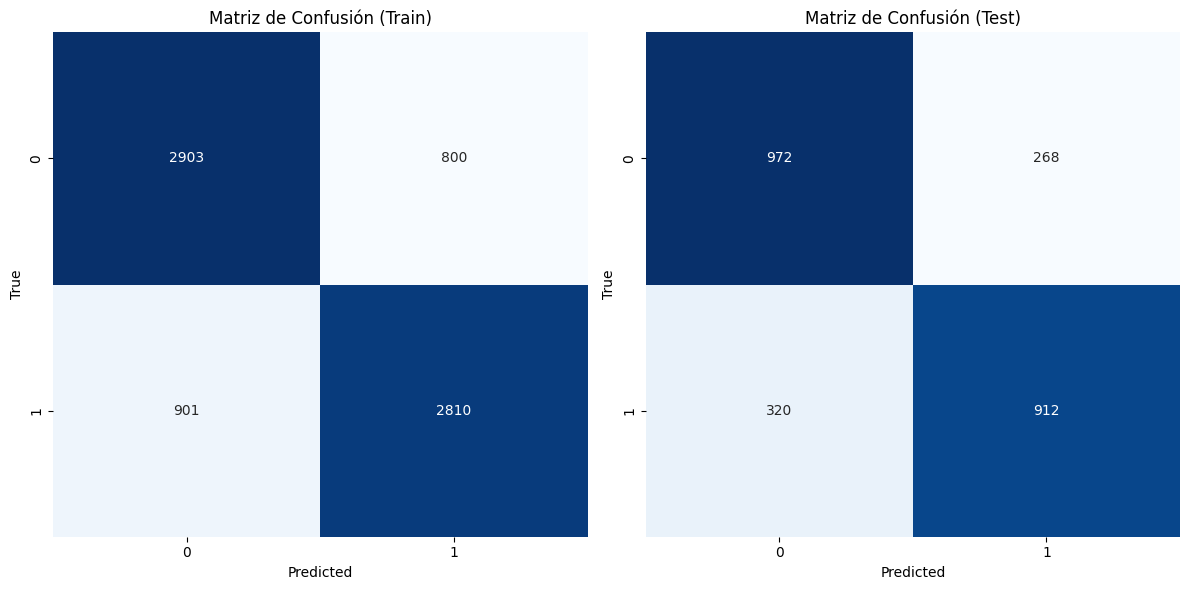

Metrics:
  Accuracy (Train):  0.7706
  Accuracy (Test):   0.7621
  Precision (Train): 0.7784
  Precision (Test):  0.7729
  Recall (Train):    0.7572
  Recall (Test):     0.7403
  F1 Score (Train):  0.7677
  F1 Score (Test):   0.7562
  ROC AUC (Train):   0.7706
  ROC AUC (Test):    0.7621


In [ ]:
#Aplicamos regularización l1 y entrenamos el modelo

model_l1 = LogisticRegression(penalty='l1', solver='liblinear')
model_l1.fit(X_train, y_train)

#Predecimos y

y_pred_l1_train = model_l1.predict(X_train)

y_pred_l1_test = model_l1.predict(X_test)

evaluate_model(y_train, y_test, y_pred_l1_train, y_pred_l1_test, 'log_reg_L1')

Aprovechemos esta oportunidad para mirar qué features son las que más contribuyen a la construcción del modelo de regresion logística.
Lo hacemos luego de aplicar regularización valiendonos de que la misma ya redujo el valor de los beta de las features que menor grado de contribución tenian.


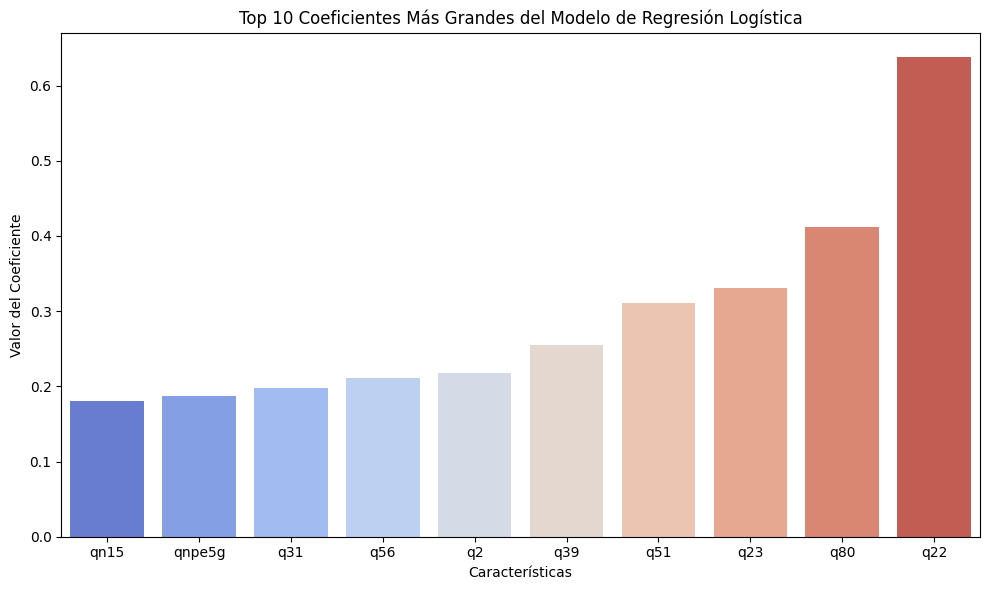

In [ ]:
coeficientes = model_l1.coef_[0]
coeficientes = np.abs(coeficientes)
top_indices = np.argsort(np.abs(coeficientes))[-10:]
top_coeficientes = coeficientes[top_indices]
top_features = np.array(X.columns)[top_indices]
coef_df = pd.DataFrame({'Coeficientes': top_coeficientes, 'Características': top_features})
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Características', y='Coeficientes', palette='coolwarm')
plt.xlabel('Características')
plt.ylabel('Valor del Coeficiente')
plt.title('Top 10 Coeficientes Más Grandes del Modelo de Regresión Logística')
plt.tight_layout()
plt.show()

Las preguntas:
"Durante los últimos 12 meses ¿con qué frecuencia te sentiste solo o sola?",
"Durante los últimos 30 días ¿con qué frecuencia tus padres o cuidadores te hicieron sentir ridículo o te menospreciaron/subestimaron (por ejemplo, diciendo que sos un tonto o inútil)?" y
"Durante los últimos 12 meses ¿con qué frecuencia estuviste tan preocupado por algo que no podías dormir por la noche?"
Son las que conforman el podio de las que mayor contribución tienen.

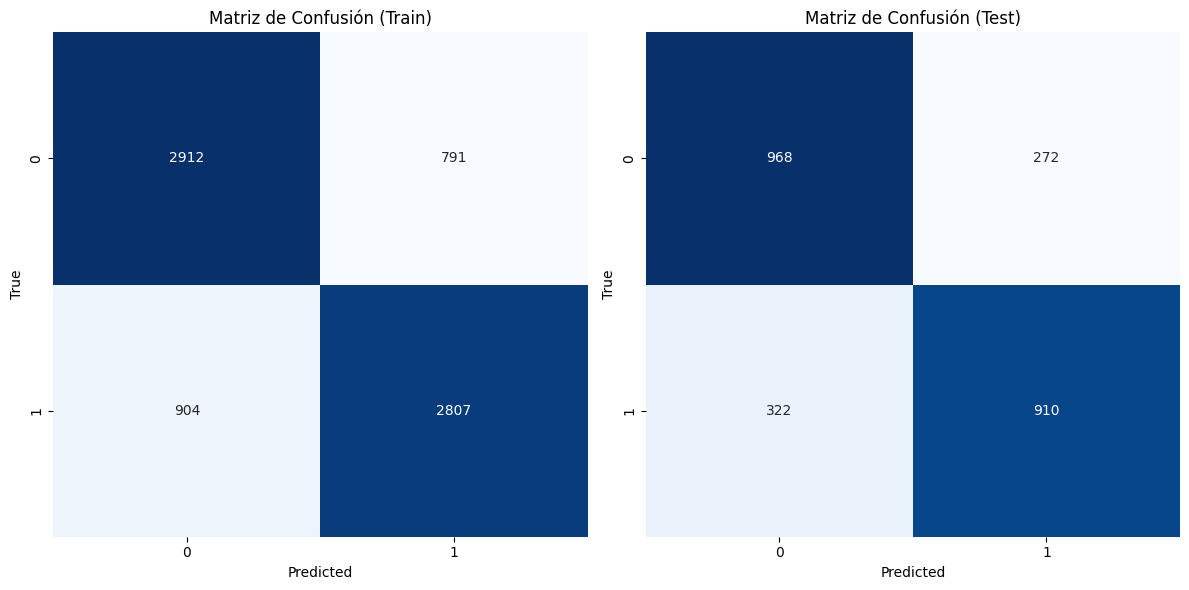

Metrics:
  Accuracy (Train):  0.7714
  Accuracy (Test):   0.7597
  Precision (Train): 0.7802
  Precision (Test):  0.7699
  Recall (Train):    0.7564
  Recall (Test):     0.7386
  F1 Score (Train):  0.7681
  F1 Score (Test):   0.7539
  ROC AUC (Train):   0.7714
  ROC AUC (Test):    0.7596


In [ ]:
#regularización l2
model_l2 = LogisticRegression(penalty='l2')
model_l2.fit(X_train, y_train)

#Predecimos y
y_pred_l2_train = model_l2.predict(X_train)

y_pred_l2_test = model_l2.predict(X_test)

evaluate_model(y_train, y_test, y_pred_l2_train, y_pred_l2_test, 'log_reg_L2')

## Comparando métricas

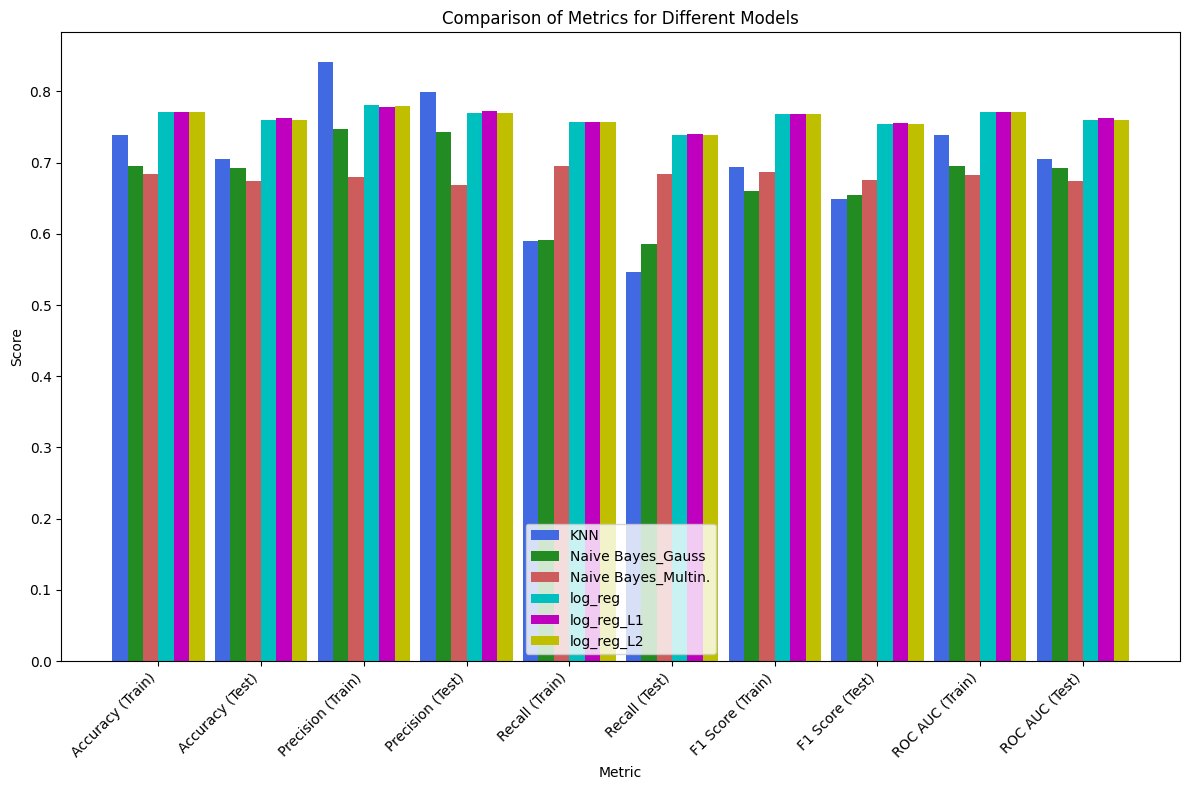

In [ ]:
# Comparemos las métricas que obtuvimos
# Para eso usamos el diccionario "results" que estuvimos usando

# Sacamos de el los modelos usados en el TP, sus nombre y métricas, y cosntruimos un grafico de barras para poder visualizarlo

model_names = list(result.keys())
metrics = list(result[model_names[0]].keys())

plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

bar_width = 0.15

pos = np.arange(len(metrics))


colors = ['royalblue', 'forestgreen', 'indianred', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown']

for i, model_name in enumerate(model_names):
    metric_values = [result[model_name][metric] for metric in metrics]
    ax.bar(pos + i * bar_width, metric_values, bar_width, label=model_name, color=colors[i])



ax.set_xticks(pos + bar_width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, ha='right')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Comparison of Metrics for Different Models')
plt.legend(loc='lower center')

plt.tight_layout()
plt.show()

In [ ]:
# Veamos cómo son las curvas ROC para las mejores versiones de los tres tipos de modelos que implementamos.
# Para ello necesitaremos no solo la predicción qué cada modelo hace sino tambien la probabilidad que el modelo le asigna.
# Obtendremos eso para cada uno de ellos:

y_probs_knn = model_knn.predict_proba(X_test)
fpr_knn,tpr_knn,thr_knn = roc_curve(y_test, y_probs_knn[:,1])
df_knn = pd.DataFrame(dict(fpr_knn=fpr_knn, tpr_knn=tpr_knn))

y_probs_l1 = model_l1.predict_proba(X_test)
fpr_l1,tpr_l1,thr_l1 = roc_curve(y_test, y_probs_l1[:,1])
df_l1 = pd.DataFrame(dict(fpr_l1=fpr_l1, tpr_l1=tpr_l1))

y_probs_mnb = model_bayes.predict_proba(X_test)
fpr_mnb,tpr_mnb,thr_mnb = roc_curve(y_test, y_probs_mnb[:,1])
df_mnb = pd.DataFrame(dict(fpr_mnb=fpr_mnb, tpr_mnb=tpr_mnb))

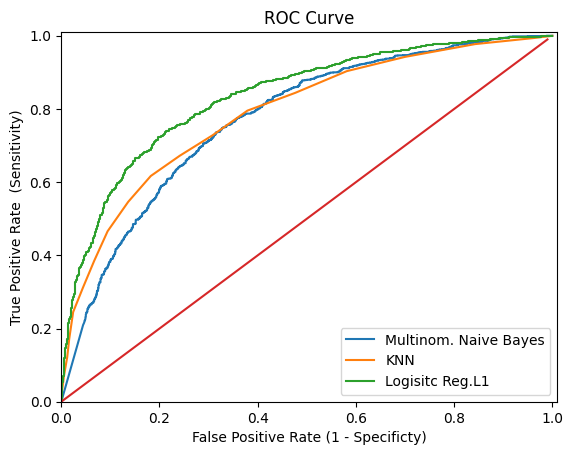

In [ ]:
# Y graficamos

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('False Positive Rate (1 - Specificty)')
plt.ylabel('True Positive Rate  (Sensitivity)')
plt.title('ROC Curve')
plt.plot(df_mnb['fpr_mnb'],df_mnb['tpr_mnb'], label='Multinom. Naive Bayes')
plt.plot(df_knn['fpr_knn'],df_knn['tpr_knn'], label='KNN')
plt.plot(df_l1['fpr_l1'],df_l1['tpr_l1'], label='Logisitc Reg.L1')
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend()
plt.show()


Como podiamos ver por las métricas anteriormente descriptas, el modelos que muestra el mejor desempeño (se asemaja más al registro perfecto donde la sensibilidad y la tasa de verdaderos positivos es siempre máxima) es el modelo de regresión logística, seguido de cerca de Naive Bayes. KNN queda muy relegado por su alta tasa de errores, más cercana a la diagonal descripta por una clasificación por azar.

## Discusión

KNN es un modelo simple, que no tiene suposiciónes sobre la distrubición de los datos, y sumamente flexible. Sin embargo no se desempeña bien cuando la cantidad de features es muy elevada y en especial cuando las features son categóricas y en este problema, muchas de las features son categóricas no ordinarias.

En cuanto a Naive Bayes, podemos destacar que hay dos modelos posibles:
*   Naive Bayes Gaussiano: se utiliza generalmente cuando las features son continuas y siguen una distribucion normal.
*   Naive Bayes Multinomial: se utiliza para features discretas.



El modelo gaussiano funciona asumiendo que las features son continuas. Sorprendentemente se adpató muy bien a nuestro dataset. Asumimos que se nutrió específicamente de las features con relación de orden inherente (las ordinales).
Sin embargo, cuando pasamos el modelo multinomial, especialmente diseñado para features discretas, el desempeño mejora.

Por el lado de la regresión logistica, pareciera ser el modelo que mejor desempeño presenta, dadas las métricas estudiadas. Esto puede deberse a que es un modelo que sufre menos que los otros enfrentarse a problemas de alta dimensionalidad asi como que es capaz de captar relaciones de orden entre features categóricas. Por otro lado, puede deberse simplemente a naturaleza del modelo! Quizas este problema cuenta con una relación lineal entre las columnas predictoras y la target y la regresion logistica logro capturar esa esensia.


Por los resultados de las métricas consideramos que el mejor modelo a aplicar es
la regresión logística con regularización L1, ya que, el tanto el accuracy score pero sobre el recall que arroja son los más altos. Damos más importancia al recall frente a los demás, ya que, queremos evitar los falsos negativos por encima de las demás variables de la matriz de confusión debido a la naturaleza del dataset que explicaremos en el siguiente texto.

Consideramos que un abordaje como el que encaramos para este trabajo puede ser util para el diseño de politicas públicas. Si un análisis más completo y complejo a este arroja también como resultado que mediante preguntas sencillas sobre salud, hábitos alimenticios y acompañamiento familiar, etc, se puede predecir si el chico o chica consideró seriamente quitarse la vida,  esta sería evidencia contundente de que es necesario avocar recursos a cubrir estos aspectos si se desea reducir la tasa de suicidio en este grupo etareo. En el mismo sentido, esta puede volverse una herramienta útil para predecir  pensamientos o comportamientios que conduzcan al suicidio, sin la necesitar de recurrir al preguntar explícitamente por él, que quizas, tratandose de personas tan jovénes puede producir verguenza o miedo y llevarlos a mentir.

Volviendo a temas de este curso, entendemos que de los tipos de errores comúnes en la aplicación de modelos, el más grave y prioritario a detectar en nuestro trabajo son los falsos negativos, ya que llevarian a que se considere que un chico o chica no consideró suicidarse, cuando en realidad sí lo hizo. De cometer este error, se habrá negado un posible ayuda, acompañamiento o intento de persuadiación desde el Estado, Institución escolar o quien sea que use esta  herramienta.

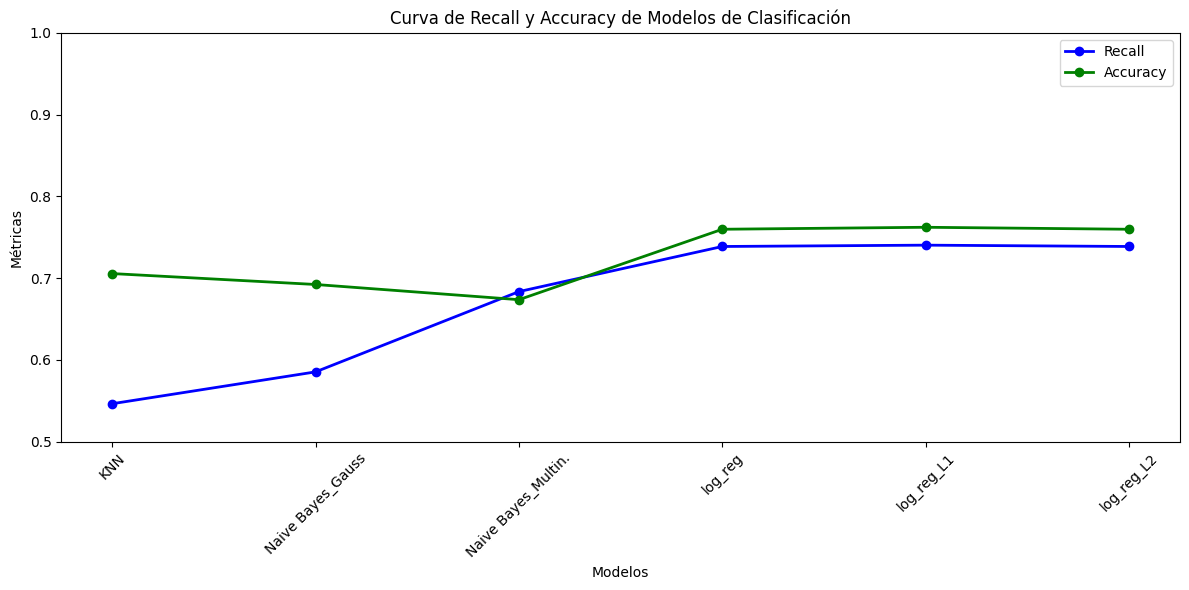

In [ ]:
models = list(result.keys())
precisions = [result[model]['Recall (Test)'] for model in models]
accuracies = [result[model]['Accuracy (Test)'] for model in models]

plt.figure(figsize=(12, 6))
plt.plot(models, precisions, marker='o', color='b', linestyle='-', linewidth=2, label='Recall')

plt.plot(models, accuracies, marker='o', color='g', linestyle='-', linewidth=2, label='Accuracy')

plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Curva de Recall y Accuracy de Modelos de Clasificación')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()